## Data Acquisition

In [35]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../')

In [36]:
from Modules.scraping import *
from Modules.supportFunctions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
data = cut_down(scrap_covid_data())

# START scraping
### Requesting url nr 1
### Requesting url nr 2
### Requesting url nr 3
# END scraping


In [38]:
# Rescaling core features
def scale_features_by_state(df, STATES):
    for state in STATES:
        df.loc[df['Province/State'] == state, "Deaths"] = df[df['Province/State'] == state].Deaths.transform(lambda x: x*(1/x.max())).fillna(0)
        df.loc[df['Province/State'] == state, "Infected"] = df[df['Province/State'] == state].Infected.transform(lambda x: x*(1/x.max())).fillna(0)
        df.loc[df['Province/State'] == state, "Recovered"] = df[df['Province/State'] == state].Recovered.transform(lambda x: x*(1/x.max())).fillna(0)
    return df

In [39]:
def find_timepoint_zero(df):
    df["Timepoint"] = -1

    point_zero = df.loc[df['Infected']>0, "Date"][0]
    df.loc[df['Date'] == point_zero, "Timepoint"] = 0

    previous = -1
    for i, row in df.iterrows():
        if i == point_zero or previous != -1:
            previous = previous + 1
            df.at[i,'Timepoint'] = previous
            
    return df

## China

In [40]:
# Get chinese data
CH = country_filter(data, Country='China')

#Calculate the distance to Hubei 
CH['Distance'] = np.square(np.power(CH['Long']-CH.loc[CH['Province/State']=='Hubei','Long'],2)+np.power(CH['Lat']-CH.loc[CH['Province/State']=='Hubei','Lat'],2))

# Get stated ordered by distance
STATES_CH = CH.sort_values('Distance')['Province/State'].drop_duplicates()

CH = scale_features_by_state(CH, STATES_CH)

In [41]:
close_states_ch = CH[CH['Province/State'].isin(STATES_CH[:int(len(STATES_CH)/4)])]
mid_close_ch =  CH[CH['Province/State'].isin(STATES_CH[int(len(STATES_CH)/4):int(len(STATES_CH)/4)*2])]
mid_far_ch =  CH[CH['Province/State'].isin(STATES_CH[2*int(len(STATES_CH)/4):int(len(STATES_CH)/4)*3])]
far_states_ch =  CH[CH['Province/State'].isin(STATES_CH[3*int(len(STATES_CH)/4):])]

Text(0.5, 1.0, 'close_states_ch')

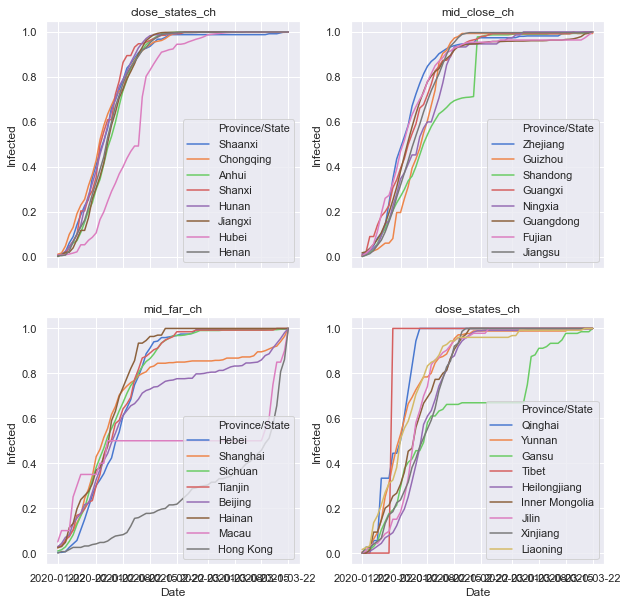

In [42]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid", palette="muted", color_codes=True)

f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
sns.lineplot(x="Date", y="Infected", hue="Province/State", data=close_states_ch, ax=axes[0, 0]).set_title("close_states_ch")
sns.lineplot(x="Date", y="Infected", hue="Province/State", data=mid_close_ch, ax=axes[0, 1]).set_title("mid_close_ch")
sns.lineplot(x="Date", y="Infected", hue="Province/State", data=mid_far_ch, ax=axes[1, 0]).set_title("mid_far_ch")
sns.lineplot(x="Date", y="Infected", hue="Province/State", data=far_states_ch, ax=axes[1, 1]).set_title("close_states_ch")

### South Korea

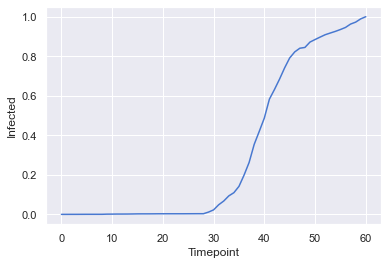

In [43]:
# South Korea
SK = country_filter(data, Country='Korea, South')
SK = find_timepoint_zero(SK)
SK = scale_features_by_state(SK, SK['Province/State'].drop_duplicates())
SK = SK[SK.Timepoint != -1]
ax = sns.lineplot(x="Timepoint", y="Infected", data=SK)

In [44]:
SK.head(10)

,Province/State,Country/Region,Lat,Long,Date,Infected,Deaths,Recovered,Timepoint
Date,,,,,,,,,
2020-01-22,"Korea, South","Korea, South",36.0,128.0,2020-01-22,0.000112,0.0,0.0,0
2020-01-23,"Korea, South","Korea, South",36.0,128.0,2020-01-23,0.000112,0.0,0.0,1
2020-01-24,"Korea, South","Korea, South",36.0,128.0,2020-01-24,0.000225,0.0,0.0,2
2020-01-25,"Korea, South","Korea, South",36.0,128.0,2020-01-25,0.000225,0.0,0.0,3
2020-01-26,"Korea, South","Korea, South",36.0,128.0,2020-01-26,0.000337,0.0,0.0,4
2020-01-27,"Korea, South","Korea, South",36.0,128.0,2020-01-27,0.000450,0.0,0.0,5
2020-01-28,"Korea, South","Korea, South",36.0,128.0,2020-01-28,0.000450,0.0,0.0,6
2020-01-29,"Korea, South","Korea, South",36.0,128.0,2020-01-29,0.000450,0.0,0.0,7
2020-01-30,"Korea, South","Korea, South",36.0,128.0,2020-01-30,0.000450,0.0,0.0,8
